In [2]:
GCS_PATH="/home/apsisdev/ansary/DATASETS/APSIS/NID/detect/"
#----------------
# imports
#---------------
import tensorflow as tf
import random
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm

#from kaggle_datasets import KaggleDatasets
from glob import glob
from tqdm.auto import tqdm

%matplotlib inline

Segmentation Models: using `tf.keras` framework.


In [3]:
#-------------
# GCS and files and synth
#-------------
def get_tfrecs(_path):
    gcs_pattern=os.path.join(_path,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    random.shuffle(file_paths)
    return file_paths

train_recs =[]
eval_recs=[]
# synth
#GCS_PATH = KaggleDatasets().get_gcs_path('aps-memo-sep')  
gcs_path_base=os.path.join(GCS_PATH,"tfrecords")

base_recs =get_tfrecs(gcs_path_base)
train_recs+=base_recs[10:]
eval_recs +=base_recs[:10]



print(len(eval_recs),len(train_recs))

10 147


In [4]:
#-------------------------------------------------------------
# Detect hardware, return appropriate distribution strategy
#-------------------------------------------------------------

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    tf.config.optimizer.set_jit(True)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

REPLICAS:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#-------------
# data function with tf.data api
#-------------
DIM=(256,256,3)
def data_input_fn(recs): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature([],tf.string),
                    'charmap' : tf.io.FixedLenFeature([],tf.string),
                    'linkmap' : tf.io.FixedLenFeature([],tf.string)
        }     
        parsed_example=tf.io.parse_single_example(example,feature)
        # image
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=3)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,DIM)
        
        # charmap
        charmap=parsed_example['charmap']
        charmap=tf.image.decode_png(charmap,channels=1)
        charmap=tf.cast(charmap,tf.float32)/255.0
        charmap=tf.reshape(charmap,(DIM[0],DIM[1],1))
        
        # linkmap
        linkmap=parsed_example['linkmap']
        linkmap=tf.image.decode_png(linkmap,channels=1)
        linkmap=tf.cast(linkmap,tf.float32)/255.0
        linkmap=tf.reshape(linkmap,(DIM[0],DIM[1],1))
        
        
        target=tf.concat([linkmap,charmap], -1)
        
        return image,target

    dataset = tf.data.TFRecordDataset(recs)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(2048,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [14]:
#-------------------------
# train and data paras
#-----------------------
EPOCHS          = 100
if strategy.num_replicas_in_sync==1:
    BATCH_SIZE = 32
else:
    BATCH_SIZE      = 8 * strategy.num_replicas_in_sync

STEPS_PER_EPOCH = (len(train_recs)*128)//BATCH_SIZE
EVAL_STEPS      = (len(eval_recs)*128)//BATCH_SIZE
print("Steps:",STEPS_PER_EPOCH)
print("Eval Steps:",EVAL_STEPS)

Steps: 588
Eval Steps: 40


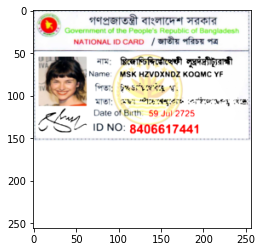

(256, 256, 2)


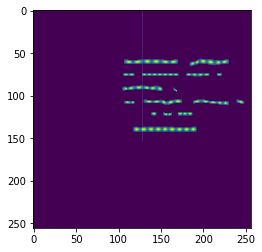

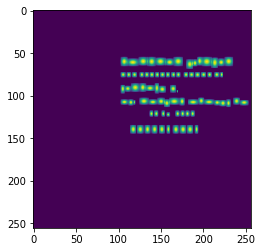

Image Batch Shape: (32, 256, 256, 3)
Target Batch Shape: (32, 256, 256, 2)


In [15]:
#-----------------------
# visual
#-----------------------
train_ds  =   data_input_fn(train_recs)
eval_ds   =   data_input_fn(eval_recs)
for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    data=np.squeeze(y[0])
    print(data.shape)
    for i in range(2):
        im=data[:,:,i]
        plt.imshow(np.squeeze(im))
        plt.show()

    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    

In [16]:
#---------------
# callbacks
#---------------
# weight file path
weight_path="craft_new.h5"

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)
# saves the model
model_autosave = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                   monitor='val_loss', 
                                                   verbose=1, 
                                                   save_best_only=True, 
                                                   mode='min')

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 
callbacks= [model_autosave,lr_reducer,early_stopping]
                 
#---------------
# compile
#---------------    
with strategy.scope():
    # model
    model = sm.Unet('densenet121',input_shape=DIM, classes=2,encoder_weights=None)
    # compile
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError())



In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS, 
                    callbacks=callbacks)

Epoch 1/100
588/588 [==============================] - 121s 187ms/step - loss: 0.0212 - val_loss: 0.0014

Epoch 00001: val_loss improved from inf to 0.00136, saving model to craft_new.h5
Epoch 2/100
230/588 [==========>...................] - ETA: 1:03 - loss: 0.0011